In [10]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Define the options for period and interval
period_options = ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
interval_options = ['1m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

# Create dropdown widgets
period_widget = widgets.Dropdown(
    options=period_options,
    value='5d',
    description='Period:',
)

interval_widget = widgets.Dropdown(
    options=interval_options,
    value='1h',
    description='Interval:',
)

# Display widgets
display(period_widget, interval_widget)

def fetch_and_display_data(period, interval):
    gold = yf.Ticker("GC=F")
    data = gold.history(period=period, interval=interval)
    
    # Calculate OBV
    data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()
    
    # Determine colors for line segments
    colors = ['green' if data['Close'].iloc[i] > data['Close'].iloc[i-1] else 'red' for i in range(1, len(data))]
    colors.insert(0, 'green')  # First line segment
    
    # Plot price data with colored line segments
    plt.figure(figsize=(14, 10))
    
    # Plot the closing prices with colors
    plt.subplot(3, 1, 1)
    for i in range(1, len(data)):
        plt.plot(data.index[i-1:i+1], data['Close'].iloc[i-1:i+1], color=colors[i-1])
    plt.title('Gold Price and Volume Analysis')
    plt.ylabel('Price (USD)')
    plt.legend(['Close Price'], loc='upper left')
    
    # Plot the volume data with colored line segments
    plt.subplot(3, 1, 2)
    for i in range(1, len(data)):
        plt.plot(data.index[i-1:i+1], data['Volume'].iloc[i-1:i+1], color=colors[i-1])
    plt.ylabel('Volume')
    plt.legend(['Volume'], loc='upper left')
    
    # Plot OBV
    plt.subplot(3, 1, 3)
    plt.plot(data.index, data['OBV'], label='On-Balance Volume (OBV)', color='purple')
    plt.ylabel('OBV')
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    
    plt.show()
    
    # Show the latest gold price
    latest_price = data['Close'].iloc[-1]
    print(f"Latest gold price: ${latest_price:.2f}")
    
    # Analyzing the results
    # Summary of buying vs. selling pressure
    if data['OBV'].iloc[-1] > data['OBV'].iloc[0]:
        print("Overall, there was more buying demand.")
    else:
        print("Overall, there was more selling demand.")
    
    # Current demand analysis
    if data['Close'].iloc[-1] > data['Close'].iloc[-2]:
        current_demand = "Buying"
        print("Currently, there is more buying demand.")
    else:
        current_demand = "Selling"
        print("Currently, there is more selling demand.")

# Create an interactive output
widgets.interact(fetch_and_display_data, period=period_widget, interval=interval_widget)


Dropdown(description='Period:', index=1, options=('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'y…

Dropdown(description='Interval:', index=6, options=('1m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', …

interactive(children=(Dropdown(description='Period:', index=1, options=('1d', '5d', '1mo', '3mo', '6mo', '1y',…

<function __main__.fetch_and_display_data(period, interval)>

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Define the options for period and interval
period_options = ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
interval_options = ['1m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

# Create dropdown widgets
period_widget = widgets.Dropdown(
    options=period_options,
    value='5d',
    description='Period:',
)

interval_widget = widgets.Dropdown(
    options=interval_options,
    value='1h',
    description='Interval:',
)

# Display widgets
display(period_widget, interval_widget)

def fetch_and_forecast(period, interval):
    # Fetch data based on user input
    gold = yf.Ticker("GC=F")
    data = gold.history(period=period, interval=interval)
    
    # Ensure data is sorted by date
    data = data.sort_index()
    
    # Resample data to ensure regular hourly frequency if needed
    if interval != '1d':  # Daily interval doesn't need resampling
        data = data.resample('h').ffill()  # Forward fill to handle missing data
    
    # Create features
    data['Return'] = data['Close'].pct_change()
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data = data.dropna()

    # Define and fit the ARIMA model
    model = ARIMA(data['Close'], order=(5, 1, 0))  # (p,d,q) parameters
    model_fit = model.fit()

    # Forecast the next hour's price
    forecast = model_fit.get_forecast(steps=1)
    forecast_mean = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()

    # Print predicted price
    predicted_price = forecast_mean.iloc[0]
    print(f'Predicted price: {predicted_price}')

    # Show the latest gold price
    latest_price = data['Close'].iloc[-1]
    print(f"Latest gold price: ${latest_price:.2f}")

    # Plot historical data and forecast
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Historical Prices', color='blue')
    plt.axvline(x=data.index[-1], color='gray', linestyle='--', label='Forecast Start')

    # Adding forecast point
    forecast_time = data.index[-1] + pd.DateOffset(hours=1)
    plt.scatter(forecast_time, predicted_price, color='red', label='Forecasted Price', zorder=5)

    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title('Gold Price Forecast')
    plt.legend()
    plt.show()

# Create an interactive output
widgets.interact(fetch_and_forecast, period=period_widget, interval=interval_widget)


Dropdown(description='Period:', index=1, options=('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'y…

Dropdown(description='Interval:', index=6, options=('1m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', …

interactive(children=(Dropdown(description='Period:', index=1, options=('1d', '5d', '1mo', '3mo', '6mo', '1y',…

<function __main__.fetch_and_forecast(period, interval)>

Dropdown(description='Period:', index=1, options=('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'y…

Dropdown(description='Interval:', index=6, options=('1m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', …

Button(description='Refresh Plot', style=ButtonStyle())

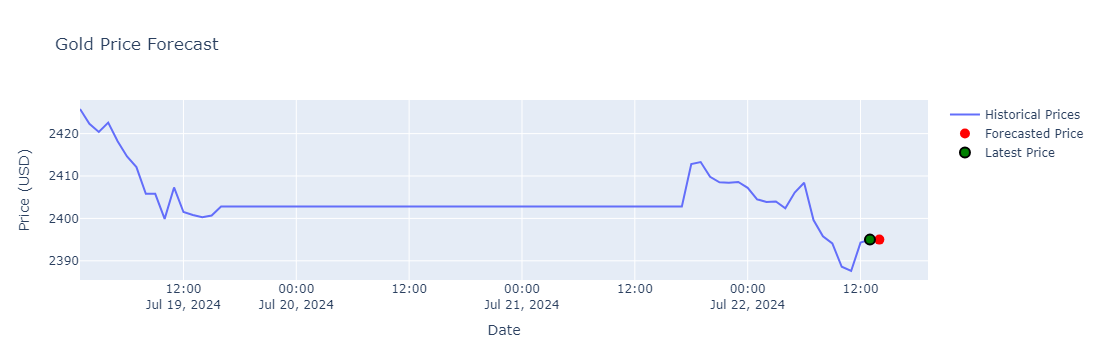

In [8]:
import yfinance as yf
import pandas as pd
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define options for period and interval
period_options = ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
interval_options = ['1m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

# Create dropdown widgets
period_widget = widgets.Dropdown(
    options=period_options,
    value='5d',
    description='Period:',
)

interval_widget = widgets.Dropdown(
    options=interval_options,
    value='1h',
    description='Interval:',
)

# Create a refresh button
refresh_button = widgets.Button(
    description='Refresh Plot'
)

# Display widgets
display(period_widget, interval_widget, refresh_button)

def fetch_data(period, interval):
    gold = yf.Ticker("GC=F")
    data = gold.history(period=period, interval=interval)
    data = data.sort_index()
    if interval != '1d':
        data = data.resample('h').ffill()
    data['Return'] = data['Close'].pct_change()
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data = data.dropna()
    return data

def update_plot(period, interval):
    data = fetch_data(period, interval)
    fig = go.Figure()
    
    # Add historical data
    fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Historical Prices'))
    
    # Add forecast point (using latest data as placeholder)
    forecast_time = data.index[-1] + pd.DateOffset(hours=1)
    fig.add_trace(go.Scatter(x=[forecast_time], y=[data['Close'].iloc[-1]], mode='markers', name='Forecasted Price', marker=dict(color='red', size=10)))
    
    # Highlight the latest price
    fig.add_trace(go.Scatter(x=[data.index[-1]], y=[data['Close'].iloc[-1]], mode='markers', name='Latest Price', marker=dict(color='green', size=10, line=dict(color='black', width=2))))
    
    fig.update_layout(title='Gold Price Forecast', xaxis_title='Date', yaxis_title='Price (USD)')
    
    return fig

# Initial call to plot
fig = update_plot(period_widget.value, interval_widget.value)
fig.show()

# Function to update plot when widgets change
def on_change(change):
    global fig
    fig = update_plot(period_widget.value, interval_widget.value)
    clear_output(wait=True)
    display(period_widget, interval_widget, refresh_button)
    fig.show()

# Attach observers to widgets
period_widget.observe(on_change, names='value')
interval_widget.observe(on_change, names='value')

# Attach observer to refresh button
def on_refresh_click(b):
    on_change(None)

refresh_button.on_click(on_refresh_click)


In [10]:
import time

start_time = time.time()
data = fetch_data(period, interval)
print(f"Data fetching time: {time.time() - start_time:.2f} seconds")

start_time = time.time()
fig = update_plot(period, interval)
print(f"Plot updating time: {time.time() - start_time:.2f} seconds")


NameError: name 'period' is not defined